In [2]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
ula_study = []

for i in range(100):
    ula_data = np.load('ula_hyperparameters_tuning/ula_iterations_number_tuning_sigma005/ula_data_'+str(900+i)+'.npy',allow_pickle=True)
    ula_study.append(ula_data.item())

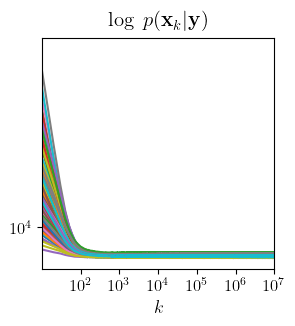

In [256]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
for i in range(len(ula_study)):
    plt.plot(ula_study[i]["ula_obj_values"])
plt.xscale("log")
#plt.yscale("log")
plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6],
           [r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=12)
plt.yticks([1e4], [r"$10^4$"], fontsize=12)
plt.xlim([1,1e6])
plt.xlabel(r"$k$", fontsize=13, labelpad=5)
#plt.ylabel(r"$\log\;p(\mathbf{x}_k | \mathbf{y})$", rotation=90, fontsize=13, labelpad=10)
plt.title(r"$\log\;p(\mathbf{x}_k | \mathbf{y})$", fontsize=15, y=1.02)

plt.savefig('../../figures/ula_tuning_logposterior.eps', format='eps', bbox_inches="tight")

plt.show()

In [5]:
obj_values = np.zeros((len(ula_study), ula_study[0]["ula_obj_values"].size))

for i in range(len(ula_study)):
    avg_plateau = np.mean(ula_study[i]["ula_obj_values"][1100:])
    obj_values[i, :] =  ula_study[i]["ula_obj_values"] / avg_plateau
mean_obj_values = np.mean(obj_values, axis=0)
std_obj_values = np.std(obj_values, axis=0)

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


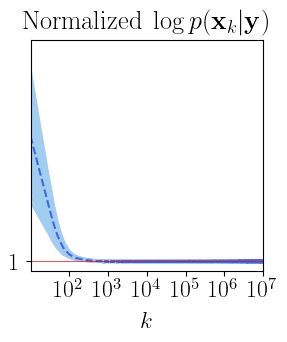

In [22]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

#plt.fill_between(np.arange(0,mean_obj_values.size), mean_obj_values-std_obj_values,  mean_obj_values+std_obj_values, color=np.array([0.62745098, 0.80588235, 0.94117647]))

upper_bound = mean_obj_values+std_obj_values
lower_bound = mean_obj_values-std_obj_values
step =  (upper_bound-lower_bound)/20

for i in range(21):
    plt.plot(lower_bound+step*i, color=np.array([0.62745098, 0.80588235, 0.94117647]), linewidth=2)
    

plt.plot(mean_obj_values, '--', color="royalblue")

plt.plot(np.ones(mean_obj_values.size),'r',linewidth=0.5)

#plt.plot(obj_values)
plt.xscale("log")

#plt.yscale("log")
#plt.yticks([1e1, 1e2], [r"$10^1$", r"$10^2$"], fontsize=12)

plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6],
           [r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=17)
#plt.yticks([1,10,20], [r"$1$", r"$10$", r"$20$"], fontsize=16)
plt.yticks([1, 30], [r"$1$", r"$30$"], fontsize=17)
plt.xlim([1,1e6])
plt.ylim([-0.001, 25])
plt.xlabel(r"$k\phantom{-K_b}$", fontsize=17, labelpad=7)
#plt.ylabel(r"$\log\;p(\mathbf{x}_k | \mathbf{y})$", rotation=90, fontsize=13, labelpad=10)
plt.title(r"$\mathrm{Normalized}\; \log p(\mathbf{x}_k | \mathbf{y})$", fontsize=19, y=1.01)

plt.savefig('../../figures/ula_tuning_logposterior_avg.eps', format='eps', bbox_inches="tight")

plt.show()

In [6]:
mapes_mean, mapes_var, mapes_std = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25))
mses_mean, mses_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 

for i in range(len(ula_study)):
    
    mean_items, var_items, std_items, mean_prad_items, var_prad_items = [], [], [], [], []
    for k in ula_study[i].keys():
        if 'mean' in k and 'prad' not in k:
            mean_items.append(ula_study[i][k])
        if 'var' in k and 'prad' not in k:
            var_items.append(ula_study[i][k])
            std_items.append(np.sqrt(ula_study[i][k]))
        if 'mean_prad' in k:
            mean_prad_items.append(ula_study[i][k])
        if 'var_prad' in k:
            var_prad_items.append(ula_study[i][k])
    mean_items, var_items, std_items = np.array(mean_items), np.array(var_items), np.array(std_items)
    mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)
    
    
    mses_mean[i,:] = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
    mape_mean = np.abs(mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))
    mean_positive_locs = np.where(mean_items[-1]>1e-3)
    mape_mean[:,mean_positive_locs[0], mean_positive_locs[1]] /= mean_items[-1][mean_positive_locs[0], mean_positive_locs[1]]
    mapes_mean[i,:] = np.mean(mape_mean[:,mean_positive_locs[0],mean_positive_locs[1]],axis=1)
    
    mses_var[i,:] = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
    mape_var = np.abs(var_items-np.stack([var_items[-1]]*var_items.shape[0]))
    var_positive_locs = np.where(var_items[-1]>1e-3)
    mape_var[:,var_positive_locs[0], var_positive_locs[1]] /= var_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_var[i,:] = np.mean(mape_var[:,var_positive_locs[0],var_positive_locs[1]],axis=1)
    
    mape_std = np.abs(std_items-np.stack([std_items[-1]]*std_items.shape[0]))
    mape_std[:,var_positive_locs[0], var_positive_locs[1]] /= std_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_std[i,:] = np.mean(mape_std[:,var_positive_locs[0],var_positive_locs[1]], axis=1)
    


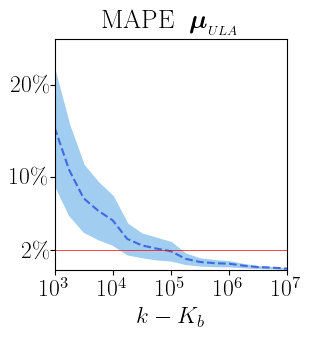

In [20]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'text.latex.preamble': r"""\usepackage{bm}""",
})
mape_mean_avg = np.mean(mapes_mean[:,8:],axis=0)
mape_mean_std = np.std(mapes_mean[:,8:],axis=0)
#plt.fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, alpha=0.5)
plt.fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, color=np.array([0.62745098, 0.80588235, 0.94117647]))
plt.plot(mape_mean_avg, '--', color="royalblue")
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=17)
#plt.yticks([0,0.02,0.1,0.2,0.3], [r"$0$",r"$2$",r"$10$",r"$20$",r"$30$"], fontsize=14)
plt.yticks([0.02,0.1,0.2,0.3], [r"$2\%$",r"$10\%$",r"$20\%$",r"$30\%$"], fontsize=17)
plt.plot(np.ones(int(17))*0.02,'r',linewidth=0.5)
plt.ylim([-0.001,0.25])
plt.xlim([0,16])
plt.title(r"$\mathrm{MAPE}\;\;\bm{\mu}_{_{ULA}}$", fontsize=19, y=1.01)
plt.xlabel(r"$k-K_b$", fontsize=17, labelpad=5)
plt.tick_params(axis='y', which='major', pad=0)

plt.savefig('../../figures/ula_tuning_mape_mean.eps', format='eps', bbox_inches="tight")
plt.show()

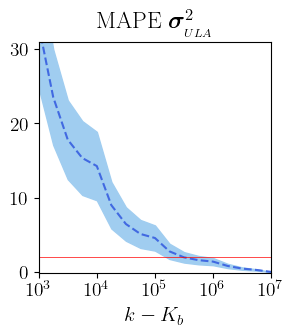

In [49]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'text.latex.preamble': r"""\usepackage{bm}""",
})
mape_var_avg = np.mean(mapes_var[:,8:],axis=0)
mape_var_std = np.std(mapes_var[:,8:],axis=0)
#plt.fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, alpha=0.5)
plt.fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, color=np.array([0.62745098, 0.80588235, 0.94117647]))
plt.plot(mape_var_avg, '--', color="royalblue")
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=14)
plt.yticks([0,0.1,0.2,0.3], [r"$0$",r"$10$",r"$20$",r"$30$"], fontsize=14)
plt.plot(np.ones(int(17))*0.02,'r',linewidth=0.5)
plt.ylim([-0.001,0.31])
plt.xlim([0,16])
plt.title(r"$\mathrm{MAPE}\;\bm{\sigma}^2_{_{ULA}}$", fontsize=17, y=1.02)
plt.xlabel(r"$k-K_b$", fontsize=15, labelpad=5)

plt.savefig('../../figures/ula_tuning_mape_var.eps', format='eps', bbox_inches="tight")
plt.show()

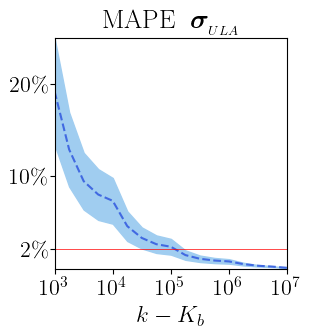

In [24]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'text.latex.preamble': r"""\usepackage{bm}""",
})
mape_std_avg = np.mean(mapes_std[:,8:],axis=0)
mape_std_std = np.std(mapes_std[:,8:],axis=0)
#plt.fill_between(np.arange(0,17), mape_std_avg-mape_std_std,  mape_std_avg+mape_std_std, alpha=0.5)
#plt.fill_between(np.arange(0,17), mape_std_avg-mape_std_std,  mape_std_avg+mape_std_std, color=np.array([0.62745098, 0.70588235, 0.94117647]))
plt.fill_between(np.arange(0,17), mape_std_avg-mape_std_std,  mape_std_avg+mape_std_std, color=np.array([0.62745098, 0.80588235, 0.94117647]))
plt.plot(mape_std_avg, '--', color="royalblue")
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=16)
#plt.yticks([0,0.02,0.1,0.2,0.3], [r"$0$",r"$2$",r"$10$",r"$20$",r"$30$"], fontsize=14)
plt.yticks([0.02,0.1,0.2,0.3], [r"$2\%$",r"$10\%$",r"$20\%$",r"$30\%$"], fontsize=16)
plt.plot(np.ones(int(17))*0.02,'r',linewidth=0.5)
plt.ylim([-0.001,0.25])
plt.xlim([0,16])
plt.title(r"$\mathrm{MAPE}\;\;\bm{\sigma}_{_{ULA}}$", fontsize=19, y=1.01)
plt.xlabel(r"$k-K_b$", fontsize=17, labelpad=5)
plt.tick_params(axis='y', which='major', pad=0)

plt.savefig('../../figures/ula_tuning_mape_std.eps', format='eps', bbox_inches="tight")
plt.show()